In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import random
from os.path import join as oj
from copy import deepcopy
import pandas as pd
import sli
sys.path.append('../../sli')
import train
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from train import train_models
out_dir = '../../results/interp'

Using TensorFlow backend.


# train 3 models

In [2]:
np.random.seed(13)
data = datasets.load_breast_cancer()
data['target_names'] = data['target_names'][::-1] # want class 1 to be "malignant", class 0 to be "benign"
X = data['data']
y = 1 - data['target'] # want class 1 to be "malignant", class 0 to be "benign"
X_train, X_test, y_train, y_test = train_test_split(X, y) # defaults to 0.75: 0.25 splitx`

In [3]:
# class_weights = [0.5, 1, 2]
class_weights = [0.2, 1, 5]
models = train_models(X_train, y_train, class_weights, model_type='logistic')
# models = train_models(X_train, y_train, class_weights, model_type='logistic')

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# model importances

In [4]:
np.random.seed(13)
x = X_test[0].reshape(1, -1)
class_num = 1
feature_names = data['feature_names']
target_name = data['target_names'][1]
strategy = 'independent' # gaussian_kde

**get feature importances**

In [5]:
explainer = sli.Explainer(X_train, feature_names=feature_names, strategy=strategy, target_name=target_name)
explainer.explain_instance(x, models[1].predict_proba, class_num, return_table=True)

,contribution,sensitivity
area error,-0.771,0.017
worst area,-0.68,0.003
worst perimeter,-0.537,0.03
mean area,-0.381,0
worst texture,-0.242,0.031
perimeter error,0.103,-0.021
mean radius,-0.082,-0.208
worst radius,-0.053,-0.212
texture error,0.046,-0.071
worst concavity,-0.024,0.144


**visualize a particular feature locally**

contribution: -0.771, sensitivity pos: 0.017


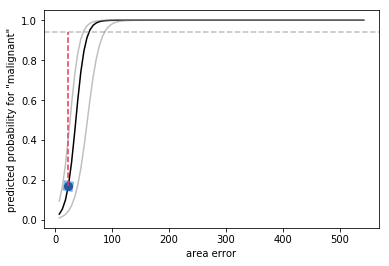

In [6]:
feature_name = 'area error' # area error
fig = plt.figure()
expl_dicts = []
for i in range(3):
    expl_dicts.append(explainer.explain_instance_feature(x, models[i].predict_proba, 
                                                         feature_name=feature_name, class_num=class_num))

print(f'contribution: {expl_dicts[1]["contribution"]:0.3f}, sensitivity pos: {expl_dicts[1]["sensitivity_pos"]:0.3f}')

explainer.viz_expl_feature(expl_dicts[1], [expl_dicts[0], expl_dicts[2]])


**visualize all features interactively**

In [7]:
explainer.calc_percentiles(models[1].predict_proba, models[0].predict_proba, 
                           models[2].predict_proba)

In [8]:
expl_dicts = []
for i in range(3):
    expl_dicts.append(explainer.explain_instance(x, models[i].predict_proba, class_num, return_table=False))
explainer.viz_expl(expl_dicts[1], [expl_dicts[0], expl_dicts[2]], 
                   point_id='', filename=oj(out_dir, 'out_breast_cancer.html'), 
                   show_stds=True)

# uncertainty plots

In [67]:
from metrics import get_metrics

In [ ]:
metrics_train = get_metrics(models[0].predict_proba(X_train)[:, 1], 
                            models[1].predict_proba(X_train)[:, 1], models[2].predict_proba(X_train)[:, 1], 
                            y_train, suffix='train')
metrics_test = get_metrics(models[0].predict_proba(X_test)[:, 1], 
                           models[1].predict_proba(X_test)[:, 1], models[2].predict_proba(X_test)[:, 1], 
                           y_test, suffix='test')

dict_keys(['cw_flipped_diff_test', 'cw_flipped_diff_p_test', 'cw_loss_percentages_test', 'cw_loss_performances_test', 'cw_loss_auc_test', 'cw_auc_percentages_test', 'cw_auc_performances_test', 'cw_auc_auc_test', 'cw_calibration_pred_test', 'cw_calibration_true_test', 'cw_calibration_rmse_test', 'cw_ranks_test', 'cw_uncertainty_test', 'pe_flipped_diff_test', 'pe_flipped_diff_p_test', 'pe_loss_percentages_test', 'pe_loss_performances_test', 'pe_loss_auc_test', 'pe_auc_percentages_test', 'pe_auc_performances_test', 'pe_auc_auc_test', 'pe_calibration_pred_test', 'pe_calibration_true_test', 'pe_calibration_rmse_test', 'pe_ranks_test', 'pe_uncertainty_test', 'preds'])


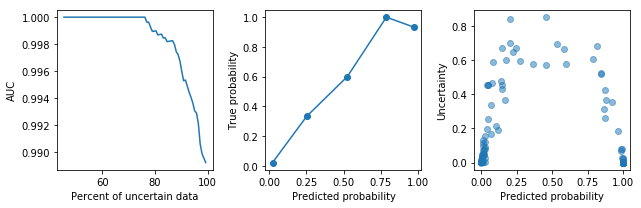

In [69]:
R, C = 1, 3
r = metrics_test
# print(r.keys())
plt.figure(figsize=(C * 3, R * 3))

plt.subplot(R, C, 1)
plt.plot(r['cw_auc_percentages_test'], r['cw_auc_performances_test'])
plt.xlabel('Percent of uncertain data')
plt.ylabel('AUC')

plt.subplot(R, C, 2)
plt.plot(r['cw_calibration_pred_test'], r['cw_calibration_true_test'], 'o-')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')

plt.subplot(R, C, 3)
plt.plot(r['preds'], r['cw_uncertainty_test'], 'o', alpha=0.5)
plt.xlabel('Predicted probability')
plt.ylabel('Uncertainty')

plt.tight_layout()
plt.savefig(oj(out_dir, 'fig_breast_cancer_uncertainty.pdf'))